In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import imageio
import matplotlib as mpl
import itertools
import os
import os.path
import glob
import sys
% matplotlib inline
from pathlib import Path
# Dataset & Utils
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils
from torchvision.utils import save_image

# Optimizer, Functions, Distributions
from torch.autograd import Variable
import torch.nn.functional as F 
import torch.optim as optim
from torch import nn 
import torch.distributions as ds


# My models, optimizer classes - VAE, Adam
import nldr.models
from nldr.models import vae, Encoder, Decoder, VAE
from nldr.models import optimizers, Optimizer
import nldr.utils
from nldr.utils.datasets import MNIST_Loader, Visualize, Caltech256, Caltech256_Loader

# Unrelated but useful
get_types = lambda x :[(a, getattr(x, a)) for a in dir(x) if not callable(getattr(x, a)) and a[0] != '_']

In [2]:
results_path = str(Path(os.getcwd())) + "/results/vae_mnist/"
data_path = str(Path(os.getcwd())) + "/data/latent/"

In [ ]:
import importlib
importlib.reload(nldr.utils)
importlib.reload(nldr.models);

In [3]:
gpu = torch.cuda.is_available()
#gpu = False
gpu

True

In [4]:
#train_loader, test_loader = MNIST_Loader(batch_size=64).load()
train_loader, test_loader = MNIST_Loader().load(batch_size=100)
classes = (0,1,2,3,4,5,6,7,8,9)

In [ ]:
# get some random training images
#dataiter = iter(train_loader)
#images, labels = dataiter.next()
#rand_image = MNIST_Loader().random_image(images)

In [ ]:
#Visualize.imshow_batch(images)
#Visualize.display_labels(classes,labels)

# Visualize a random digit from a batch
#Visualize.imshow_random(images)

### VAE Encoder/Decoder architecture

In [5]:
D_in, H, D_out = 784, 500, 36
encoder = Encoder(D_in, H, D_out)
decoder = Decoder(D_out, H, D_in)
if gpu: 
    print("Using GPU for encoder decoder")
    encoder.cuda()
    decoder.cuda()

Using GPU for encoder decoder


In [6]:
#model_vae = VAE().to(device) - if cuda is available, but not the case, yet
model_vae_ = VAE(encoder,decoder)
if gpu: 
    print("Using GPU for VAE")
    model_vae_.cuda()
optimizer = Optimizer(model_vae_,optimizer = optim.Adam(model_vae_.parameters(), lr=1e-4),early_stopping = True, gpu=gpu,results_path=results_path)
#optim.RMSprop(model_vae.parameters(), lr = 1e-3, momentum=0.9)

Using GPU for VAE


In [8]:
# Generate 64 different digits. The sample is just the mean.
# Turn on early stopping
epochs = 80
for epoch in range(1, epochs + 1):
    optimizer.train_epoch(epoch,train_loader)
    optimizer.test_epoch(epoch,test_loader)
    
    with torch.no_grad():
        sample = torch.randn(64, D_out)
        if gpu: 
            print("Sample on GPU")
            sample = sample.cuda()
        sample = model_vae_.decode(sample)
        save_image(sample.view(64, 1, 28, 28),
                   results_path+'sample_' + str(epoch) + '.png')
        
    if optimizer.early_stopping and epoch>3:
        diff = np.abs(optimizer.average_loss[-1] - optimizer.average_loss[-3])
        thres = diff/optimizer.average_loss[-1] * 100
        if thres<= 0.03:
            print("Performing early stopping .. ")
            break;    

/afs/inf.ed.ac.uk/user/s10/s1043702/miniconda3/envs/ot/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/afs/inf.ed.ac.uk/user/s10/s1043702/miniconda3/envs/ot/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1 [0/60000 (0%)]	Loss: 138.554717
Train Epoch: 1 [5000/60000 (8%)]	Loss: 139.138965
Train Epoch: 1 [10000/60000 (17%)]	Loss: 134.963281
Train Epoch: 1 [15000/60000 (25%)]	Loss: 140.886777
Train Epoch: 1 [20000/60000 (33%)]	Loss: 144.078115
Train Epoch: 1 [25000/60000 (42%)]	Loss: 140.239512
Train Epoch: 1 [30000/60000 (50%)]	Loss: 137.443301
Train Epoch: 1 [35000/60000 (58%)]	Loss: 135.395635
Train Epoch: 1 [40000/60000 (67%)]	Loss: 137.245215
Train Epoch: 1 [45000/60000 (75%)]	Loss: 142.074922
Train Epoch: 1 [50000/60000 (83%)]	Loss: 145.085996
Train Epoch: 1 [55000/60000 (92%)]	Loss: 139.156338
====> Epoch: 1 Average loss: 138.3253
====> Test set loss: 122.8785
Sample on GPU
Train Epoch: 2 [0/60000 (0%)]	Loss: 140.642988
Train Epoch: 2 [5000/60000 (8%)]	Loss: 134.727871
Train Epoch: 2 [10000/60000 (17%)]	Loss: 134.680488
Train Epoch: 2 [15000/60000 (25%)]	Loss: 135.721377
Train Epoch: 2 [20000/60000 (33%)]	Loss: 134.054873
Train Epoch: 2 [25000/60000 (42%)]	Loss: 130.942

Train Epoch: 12 [50000/60000 (83%)]	Loss: 114.928574
Train Epoch: 12 [55000/60000 (92%)]	Loss: 114.783037
====> Epoch: 12 Average loss: 113.7318
====> Test set loss: 101.1892
Sample on GPU
Train Epoch: 13 [0/60000 (0%)]	Loss: 118.609141
Train Epoch: 13 [5000/60000 (8%)]	Loss: 111.601230
Train Epoch: 13 [10000/60000 (17%)]	Loss: 119.184893
Train Epoch: 13 [15000/60000 (25%)]	Loss: 120.209131
Train Epoch: 13 [20000/60000 (33%)]	Loss: 115.739639
Train Epoch: 13 [25000/60000 (42%)]	Loss: 113.177598
Train Epoch: 13 [30000/60000 (50%)]	Loss: 112.005469
Train Epoch: 13 [35000/60000 (58%)]	Loss: 114.875459
Train Epoch: 13 [40000/60000 (67%)]	Loss: 113.063203
Train Epoch: 13 [45000/60000 (75%)]	Loss: 113.491377
Train Epoch: 13 [50000/60000 (83%)]	Loss: 115.477578
Train Epoch: 13 [55000/60000 (92%)]	Loss: 109.179736
====> Epoch: 13 Average loss: 113.0426
====> Test set loss: 100.6240
Sample on GPU
Train Epoch: 14 [0/60000 (0%)]	Loss: 110.676230
Train Epoch: 14 [5000/60000 (8%)]	Loss: 111.083066


Train Epoch: 24 [20000/60000 (33%)]	Loss: 104.709844
Train Epoch: 24 [25000/60000 (42%)]	Loss: 108.735078
Train Epoch: 24 [30000/60000 (50%)]	Loss: 103.719209
Train Epoch: 24 [35000/60000 (58%)]	Loss: 109.727529
Train Epoch: 24 [40000/60000 (67%)]	Loss: 107.243682
Train Epoch: 24 [45000/60000 (75%)]	Loss: 104.815273
Train Epoch: 24 [50000/60000 (83%)]	Loss: 105.261484
Train Epoch: 24 [55000/60000 (92%)]	Loss: 110.247217
====> Epoch: 24 Average loss: 108.4447
====> Test set loss: 96.8342
Sample on GPU
Train Epoch: 25 [0/60000 (0%)]	Loss: 108.851328
Train Epoch: 25 [5000/60000 (8%)]	Loss: 109.703984
Train Epoch: 25 [10000/60000 (17%)]	Loss: 103.821172
Train Epoch: 25 [15000/60000 (25%)]	Loss: 105.659219
Train Epoch: 25 [20000/60000 (33%)]	Loss: 103.759502
Train Epoch: 25 [25000/60000 (42%)]	Loss: 105.917695
Train Epoch: 25 [30000/60000 (50%)]	Loss: 108.533730
Train Epoch: 25 [35000/60000 (58%)]	Loss: 106.891553
Train Epoch: 25 [40000/60000 (67%)]	Loss: 109.926387
Train Epoch: 25 [45000/6

## Model Evaluation

### Optimizer stats

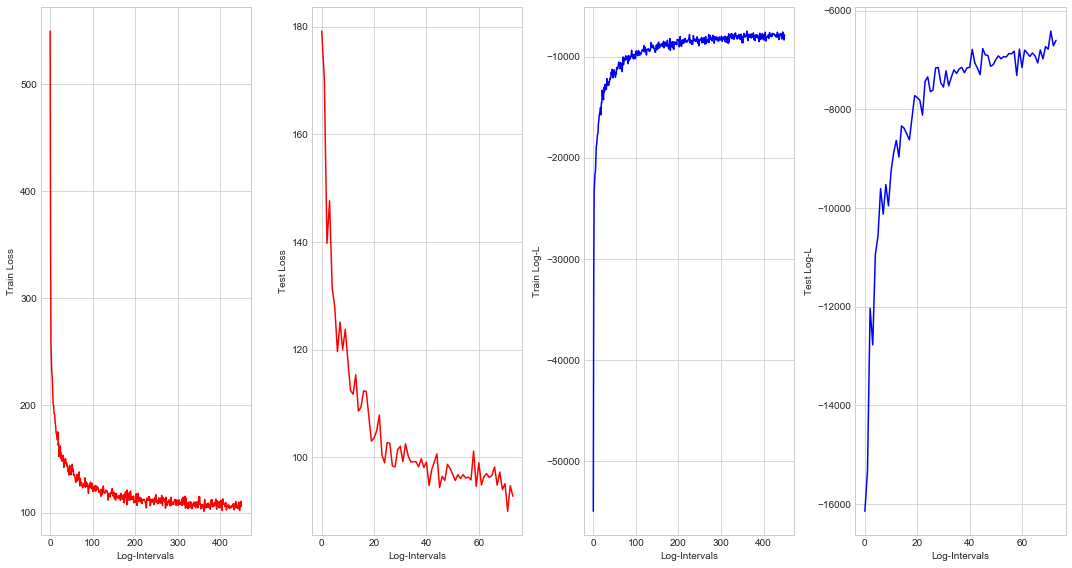

In [9]:
optimizer.show_stats(show=True,save=True)

### Save Model and Gifs

In [10]:
torch.save(model_vae_.state_dict(), "data/models" + '/VAE_36hidden_Adam_1e-4_GPU_80epochs.pkl')
# ... after training, save your model 
#model.save_state_dict('mytraining.pt')
# .. to load your previously training model:
#model.load_state_dict(torch.load('mytraining.pt'))

In [ ]:
image_gif = Visualize.make_gif(30)

### Load Model 
 * Loads trained model from disk

In [11]:
m_loaded = torch.load(f="data/models" + '/VAE_36hidden_Adam_1e-4_GPU_80epochs.pkl', map_location="cuda")
m_loaded.keys()

odict_keys(['encoder.layer1.weight', 'encoder.layer1.bias', 'encoder.layer3_mu.weight', 'encoder.layer3_mu.bias', 'encoder.layer3_logvar.weight', 'encoder.layer3_logvar.bias', 'decoder.layer1.weight', 'decoder.layer1.bias', 'decoder.layer3.weight', 'decoder.layer3.bias'])

In [12]:
model_vae_original_ = VAE(encoder,decoder).cuda()
model_vae_original_.load_state_dict(m_loaded)

### Save the encoding as .npy arrays with their labels by applying the learned VAE 
    - Train and Test and keep them separate. Full MNIST to a vector of 28 - so this is actually a lot smaller than 64 what was originally in the SIFT descriptor (8x8)
    

In [13]:
train_loader, test_loader = MNIST_Loader().load(batch_size=1000)

dataiter = iter(train_loader)
X_train, Y_train = dataiter.next()

dataiter_test = iter(test_loader)
X_test, Y_test = dataiter_test.next()

In [14]:
if gpu:
    X_train = X_train.cuda()
    print("Data on GPU")

Data on GPU


In [11]:
x = X_train[0].view(-1,784)

In [12]:
x.type()

'torch.cuda.FloatTensor'

In [15]:
encoded_mean, logvar = model_vae_original_.encode(X_train.view(-1,784))

In [16]:
print(encoded_mean.shape)
print(logvar.shape)
print(Y_train.shape)

torch.Size([1000, 36])
torch.Size([1000, 36])
torch.Size([1000])


   ### Save encoding in .npy arrays

In [17]:
np.save(data_path+"X_train_mu_36.npy",encoded_mean.detach().cpu().numpy())
np.save(data_path+"X_train_logvar_36.npy",logvar.detach().cpu().numpy())
np.save(data_path+"Y_train_36.npy",Y_train.detach().cpu().numpy())

### Load Model
    * Model needs to exist first

In [41]:
test_loader

torch.Size([100, 1, 28, 28])

In [40]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

'torch.FloatTensor'

### Plot the latent space
    * First change the number of points you plot by selecting 10000 

In [ ]:
train_loader, test_loader = MNIST_Loader().load(batch_size=10000)

dataiter = iter(train_loader)
images, labels = dataiter.next()

# Feed a new batch of images and get the mean and logvar of the latent space. 
# This gives you the parameters of the Gaussian
mu, logvar = model_vae.encode(d) 
Visualize.plot_latent_space(mu,labels)
# 2. Visualize the prior predictive distribution. Fix the latent variables between [-3,3]

### Plot the manifold
    * Generate the 2 dimensions by encoding a digit of your choice, then perturb the reconstruction with linspace
    * Plot the 2 latent dimensions/means in space with the associated digits they produce

In [ ]:
n = np.linspace(-1, 1, 20)
no_digit = 2

img = images[no_digit]
label = labels[no_digit]

In [ ]:
Visualize.plot_manifold(model_vae, n, img, label)

# Proof it's random but not entirely, when you generate
#Visualize.imshow_batch(res.view(-1,28,28).data)
#Visualize.imshow_batch(res1.view(-1,28,28).data)

# Latent Space Reduction

In [ ]:
# This is an example that aims to further reduce the latent space. 
latent_data = LatentSpaceDataset(mu,labels)
mini_train_loader = DataLoader(dataset=latent_data, batch_size = 100, shuffle=True)

#mini_data_iter = iter(mini_train_loader)
#datapoint, label = mini_data_iter.next()
D_in_latent, H_latent, D_out_latent = 20, 10, 2
encoder1 = Encoder(D_in_latent, H_latent, D_out_latent)
decoder1 = Decoder(D_out_latent, H_latent, D_in_latent)

#model_vae = VAE().to(device) - if cuda is available, but not the case, yet
model = VAE(encoder1,decoder1)
optimizer1 = Optimizer(model,optimizer = optim.Adam(model.parameters(), lr=1e-3))

# Generate 64 different digits. The sample is just the mean.
epochs = 15
for epoch in range(1, epochs + 1):
    optimizer1.train_epoch(epoch,mini_train_loader)
    #optimizer1.test_epoch(epoch,test_loader)
    
mu_latent, logvar_latent = model.encode(mu.view(-1,20))    
plot_latent_space(mu_latent,labels)